# Import modules

In [49]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from utils import heatmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A. Perfusion bioreactor (chemostat with cell retention)

## Define functions & parameters

In [70]:
# parameter values
mumax = 0.8      # 1/hour
Ks = 0.01         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.1         # g/g
Sf = 10.0         # g/liter
ms = 0.05 # g/gh
beta = 0.2 # bleed rate
gamma = 0.9 # cell retention efficiency
Fin = 2 # inlet perfusion rate

# initial values
X0 = 0.05
P0 = 0
S0 = 10
V0 = 1.0

# inlet flowrate
def F(t):
    return Fin

# outlet flowrate
## bleed flowrate
def Fbleed(t): 
    return beta*F(t)

## spent media flowrate
def Fspent(t):
    return (1-beta)*F(t)

# reaction rates
## specific cell growth rate
def mu(S):
    return mumax*S/(Ks + S)

## cell growth rate
def Rg(X,S):
    return mu(S)*X

## product formation rate
def Rp(X,S):
    return Ypx*Rg(X,S)

## substrate consumption rate 
## (assume contribution of cell maintenance & growth dominates over product formation)
def Rs(X,S): 
    return ms*X + Rg(X,S)/Yxs  

# differential equations
def xdot(x,t):
    X,P,S,V = x
    dX = -Fbleed(t)*X/V - Fspent(t)*(1-gamma)*X/V + Rg(X,S)
    dP = -F(t)*P/V + Rp(X,S)
    dS = F(t)*(Sf-S)/V - Rs(X,S)
    dV = F(t) - Fbleed(t) - Fspent(t)
    return [dX,dP,dS,dV]


## SANITY CHECKS
def cell_washout_check(Fin, V0, gamma, beta, mumax):
    cell_washout_factor = Fin/V0 * (1-gamma*(1-beta)) / mumax
    print('Cell washout factor:', round(cell_washout_factor,4), end=' >> ')
    if cell_washout_factor < 1: 
        print('No washout.')
    else: 
        print('Washout.')
    return cell_washout_factor

## Simulation

Cell washout factor: 0.7 >> No washout.
Final Substrate Concentration: 0.0233
Final Cell Concentration: 17.0541


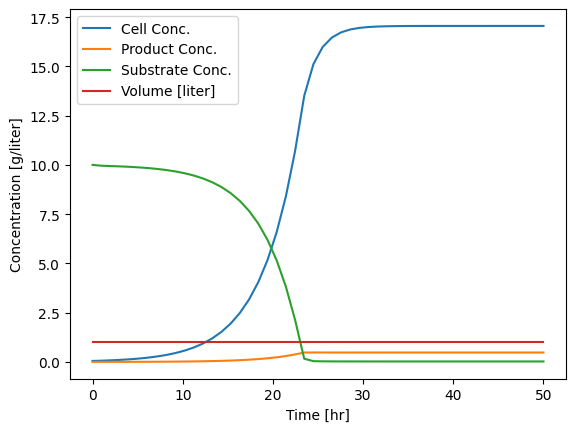

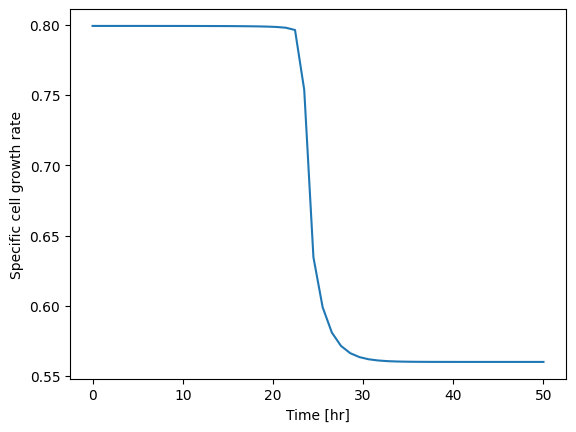

In [71]:
IC = [X0, P0, S0, V0]

t = np.linspace(0,50)
sol = odeint(xdot,IC,t)
X,P,S,V = sol.transpose()
mu_array = mu(S)

cell_washout_factor = cell_washout_check(Fin, V0, gamma, beta, mumax)
print('Final Substrate Concentration:', round(S[-1],4))
print('Final Cell Concentration:', round(X[-1],4))

plt.plot(t,X)
plt.plot(t,P)
plt.plot(t,S)
plt.plot(t,V)

plt.xlabel('Time [hr]')
plt.ylabel('Concentration [g/liter]')
plt.legend(['Cell Conc.',
            'Product Conc.',
            'Substrate Conc.',
            'Volume [liter]'])
plt.show()

plt.plot(t, mu_array)
plt.xlabel('Time [hr]')
plt.ylabel('Specific cell growth rate')
plt.show()


## Simulation with various Perfusion rate (Fin) and Bleed rate (beta) values

Max S (steady-state): 10.0
Min S (steady-state): 0.0007


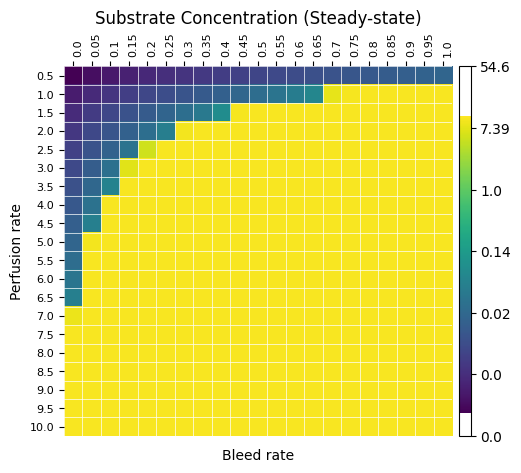

Max X (steady-state): 47.8556
Min X (steady-state): -0.0


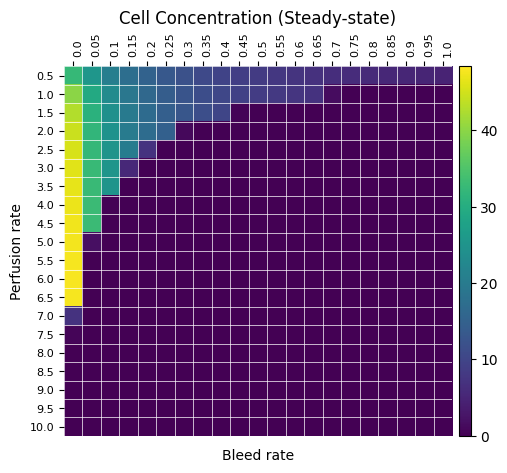

In [129]:
Fin_array = np.round(np.linspace(0.5,10, 20),3)
beta_array = np.round(np.linspace(0,1,21),3)
t = np.linspace(0,50)

# initialize arrays for storing results
Sss_array = np.zeros((len(Fin_array), len(beta_array)))
Xss_array = np.zeros((len(Fin_array), len(beta_array)))

for i, Fin in enumerate(Fin_array): 
    for j, beta in enumerate(beta_array): 
#         print(f'Perfusion rate: {round(Fin,3)}; Bleed rate: {round(beta,3)}.', end='   ')
#         cell_washout_factor = cell_washout_check(Fin, V0, gamma, beta, mumax)
        
        IC = [X0, P0, S0, V0]
        sol = odeint(xdot,IC,t)
        X,P,S,V = sol.transpose()
        mu_array = mu(S)
        
        Sss_array[i,j] = S[-1]
        Xss_array[i,j] = X[-1]
        
# plot heatmaps
print('Max S (steady-state):', round(np.max(Sss_array),4))
print('Min S (steady-state):', round(np.min(Sss_array),4))
im, cbar = heatmap(Sss_array, logscale_cmap=True, row_labels=Fin_array, col_labels=beta_array, xlabel_rotation=90, title='Substrate Concentration (Steady-state)', ylabel='Perfusion rate', xlabel='Bleed rate')
print('Max X (steady-state):', round(np.max(Xss_array),4))
print('Min X (steady-state):', round(np.min(Xss_array),4))
im, cbar = heatmap(Xss_array, logscale_cmap=False, row_labels=Fin_array, col_labels=beta_array, xlabel_rotation=90, title='Cell Concentration (Steady-state)', ylabel='Perfusion rate', xlabel='Bleed rate')

# B. Chemostat with no cell retention (standard)

## Define functions & parameters

In [68]:
# parameter values
mumax = 2      # 1/hour
Ks = 0.01         # g/liter
Yxs = 0.5         # g/g
Ypx = 0.1         # g/g
Sf = 10.0         # g/liter
ms = 0.05 # g/gh
beta = 1 # bleed rate
gamma = 0 # cell retention efficiency
Fin = 1.2

# initial values
X0 = 0.05
P0 = 0
S0 = 10
V0 = 1.0

# inlet flowrate
def F(t):
    return Fin

# outlet flowrate
## bleed flowrate
def Fbleed(t): 
    return beta*F(t)

## spent media flowrate
def Fspent(t):
    return (1-beta)*F(t)

# reaction rates
## specific cell growth rate
def mu(S):
    return mumax*S/(Ks + S)

## cell growth rate
def Rg(X,S):
    return mu(S)*X

## product formation rate
def Rp(X,S):
    return Ypx*Rg(X,S)

## substrate consumption rate 
## (assume contribution of cell maintenance & growth dominates over product formation)
def Rs(X,S): 
    return ms*X + Rg(X,S)/Yxs  

# differential equations
def xdot(x,t):
    X,P,S,V = x
    dX = -Fbleed(t)*X/V - Fspent(t)*(1-gamma)*X/V + Rg(X,S)
    dP = -F(t)*P/V + Rp(X,S)
    dS = F(t)*(Sf-S)/V - Rs(X,S)
    dV = F(t) - Fbleed(t) - Fspent(t)
    return [dX,dP,dS,dV]

## Simulation

Cell washout factor: 0.6 >> No washout.
Calculated Steady state Substrate Concentration: 0.015
Simulated Final Substrate Concentration: 0.015
Calculated Steady state Cell Concentration: 4.898
Simulated Final Cell Concentration: 4.8906


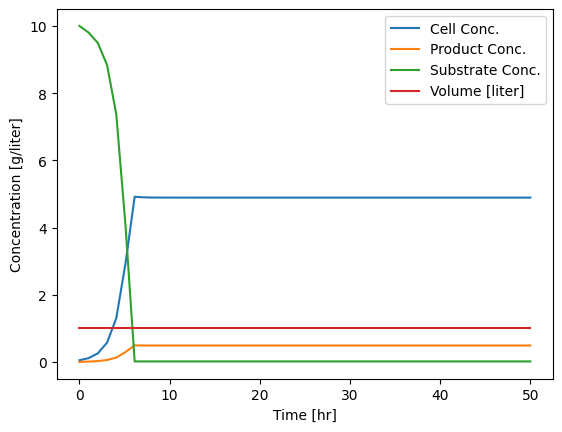

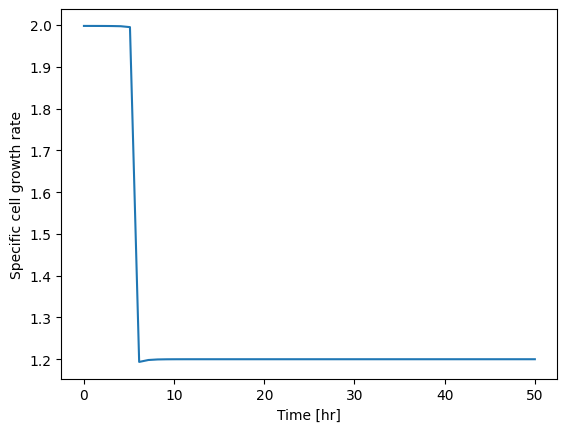

In [69]:
IC = [X0, P0, S0, V0]

t = np.linspace(0,50)
sol = odeint(xdot,IC,t)
X,P,S,V = sol.transpose()
mu_array = mu(S)

# calculate steady state values
cell_washout_factor = cell_washout_check(Fin, V0, gamma, beta, mumax)
Sss = F(0)/V0 * Ks / (mumax - F(0)/V0)
print('Calculated Steady state Substrate Concentration:', round(Sss,4))
print('Simulated Final Substrate Concentration:', round(S[-1],4))
Xss = Sf/(ms/(F(0)/V0) + 1/Yxs)
print('Calculated Steady state Cell Concentration:', round(Xss,4))
print('Simulated Final Cell Concentration:', round(X[-1],4))

plt.plot(t,X)
plt.plot(t,P)
plt.plot(t,S)
plt.plot(t,V)

plt.xlabel('Time [hr]')
plt.ylabel('Concentration [g/liter]')
plt.legend(['Cell Conc.',
            'Product Conc.',
            'Substrate Conc.',
            'Volume [liter]'])
plt.show()

plt.plot(t, mu_array)
plt.xlabel('Time [hr]')
plt.ylabel('Specific cell growth rate')
plt.show()

